# Regressions

This notebook demonstrates various regressions, and accompanies the videos in Week 8.

## Setup

We're going to import our modules.  Of particular note is `statsmodels.formula.api`, which gives us the regression APIs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps
import statsmodels.api as sm
import statsmodels.formula.api as smf

We're going to use the Penguins data:

In [2]:
penguins = pd.read_csv('../data/penguins.csv')

In [3]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


I'm also going to create a utility function for plotting lines:

In [4]:
def plot_line(intercept, slope, xmin, xmax, **kwargs):
    xs = np.linspace(xmin, xmax, 100)
    ys = intercept + slope * xs
    plt.plot(xs, ys, **kwargs)

## Explore Correlations

The Seaborn [`pairplot`](https://seaborn.pydata.org/archive/0.10/generated/seaborn.pairplot.html#seaborn.pairplot) function shows a *scatterplot matrix*, allowing us to view possible correlations:

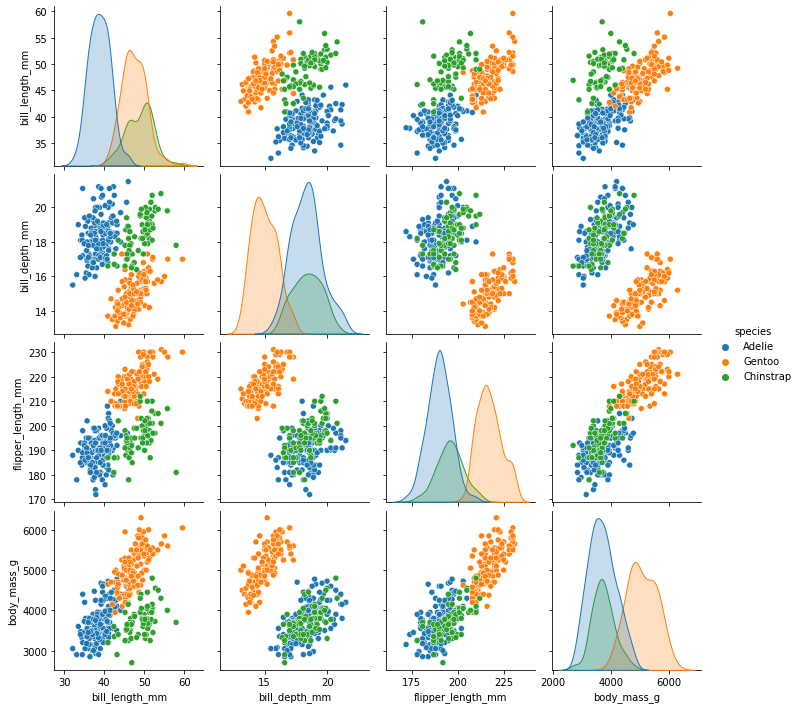

In [5]:
sns.pairplot(penguins[['species', 'sex', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']], hue='species')
plt.show()

Let's also look at the distribution of sex and species, to see if we have sex imbalances between species:

<AxesSubplot:xlabel='species', ylabel='count'>

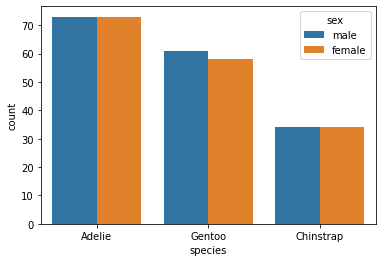

In [6]:
sns.countplot(x='species', hue='sex', data=penguins)

Nope!

Now a correlation matrix between our various numeric variables:

In [7]:
penguins.drop(columns=['year']).corr()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


The `.corr` method on a data frame will compute correlations between all pairs of numeric variables, and show them in a table.  The diagonal is 1, because a variable is always correlated with itself.

### Dummy Variable Demo

Here's the code that demonstrates dummy-coding from the Categorical Predictors lecture:

In [8]:
pd.get_dummies(penguins['species'])

,Adelie,Chinstrap,Gentoo
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
339,0,1,0
340,0,1,0
341,0,1,0
342,0,1,0


And dropping the first level:

In [9]:
pd.get_dummies(penguins['species'], drop_first=True)

,Chinstrap,Gentoo
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
339,1,0
340,1,0
341,1,0
342,1,0


## Flipper Regression

From the pair plot, the flipper length and body mass look like good candidates for regression.  Let's show them with a `regplot`:

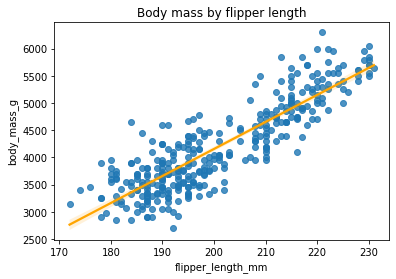

In [10]:
sns.regplot(x='flipper_length_mm', y='body_mass_g', data=penguins, line_kws={'color': 'orange'})
plt.title('Body mass by flipper length')
plt.show()

Now we're going to fit a linear regression.

The first step is to create the OLS model.  This has two inputs:

1. The formula specifying the regression model (in this case, predicting body mass with flipper length)
2. The data to train the model on

Let's do it:

In [11]:
bm_mod = smf.ols('body_mass_g ~ flipper_length_mm', data=penguins)

Once we have *created* the model, we need to *fit* it.  The [`fit`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit) method will return an object containing the results of fitting the model, such as its paramters; it can be summarized with `summary`:

In [12]:
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          4.37e-107
Time:                        15:29:50   Log-Likelihood:                -2528.4
No. Observations:                 342   AIC:                             5061.
Df Residuals:                     340   BIC:                             5069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5780.8314    305.815    -18.903      0.000   -6382.358   -5179.305
flipper_length_mm    49.6856      1.518     32.722      0.000      46.699      52.672
==============================================================================
Omnibus:                        5.634   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.585
Skew:                           0.313   Prob(JB):                       0.0613
Kurtosis:                       3.019   Cond. No.                     2.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we need to check our residual assumptions.  There are two plots to create:

* Residuals vs. Fitted 
* Residual Q-Q

I'm going to create a function that plots them both:

In [13]:
def plot_lm_diag(fit):
    "Plot linear fit diagnostics"
    sns.regplot(x=fit.fittedvalues, y=fit.resid)
    plt.xlabel('Fitted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted')
    plt.show()

    sm.qqplot(fit.resid, fit=True, line='45')
    plt.title('Residuals')
    plt.show()

And now use it:

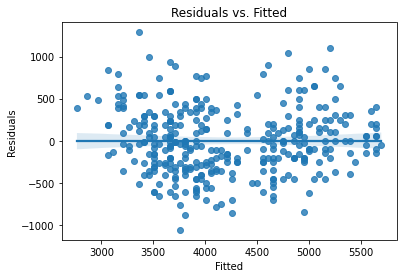

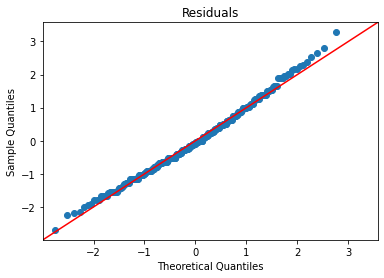

In [14]:
plot_lm_diag(bmf)

### Standardizing Variables

We can also *standardize* our variables before fitting a model.  This converts variable values into *z*-scores, such that

$$z_i = \frac{x_i - \bar{x}}{s}$$

Z-standardized (or z-normalized) variables have a mean of 0 and a standard deviation of 1 (and since $1^2 = 1$, the variance is also 1).  The result is that model coefficients are in units of standard deviations.

Let's write a function to convert a series to its *z*-scores:

In [15]:
def zscore(xs):
    xbar = xs.mean()
    s = xs.std()
    return (xs - xbar) / s

And create standardized versions of our variables:

In [16]:
penguin_std = pd.DataFrame({
    'species': penguins['species'],
    'sex': penguins['sex'],
    'mass': zscore(penguins['body_mass_g']),
    'flipper': zscore(penguins['flipper_length_mm']),
    'bill_len': zscore(penguins['bill_length_mm']),
    'bill_depth': zscore(penguins['bill_depth_mm'])
})
penguin_std

,species,sex,mass,flipper,bill_len,bill_depth
0,Adelie,male,-0.563317,-1.416272,-0.883205,0.784300
1,Adelie,female,-0.500969,-1.060696,-0.809939,0.126003
2,Adelie,female,-1.186793,-0.420660,-0.663408,0.429833
3,Adelie,NaN,NaN,NaN,NaN,NaN
4,Adelie,female,-0.937403,-0.562890,-1.322799,1.088129
...,...,...,...,...,...,...
339,Chinstrap,male,-0.251578,0.432721,2.175637,1.341320
340,Chinstrap,female,-0.999750,0.077145,-0.077282,0.480471
341,Chinstrap,male,-0.532143,-0.562890,1.040019,0.531109
342,Chinstrap,male,-0.126883,0.646066,1.259816,0.936215


And now we'll fit and describe a model using these:

In [17]:
bm_mod = smf.ols('mass ~ flipper', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1071.
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          4.37e-107
Time:                        15:29:51   Log-Likelihood:                -241.46
No. Observations:                 342   AIC:                             486.9
Df Residuals:                     340   BIC:                             494.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.75e-16      0.027   6.58e-15      1.000      -0.052       0.052
flipper        0.8712      0.027     32.722      0.000       0.819       0.924
==============================================================================
Omnibus:                        5.634   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.585
Skew:                           0.313   Prob(JB):                       0.0613
Kurtosis:                       3.019   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The residual plots will be identical to the unstandardized model, except for the scales of the axes, because all we did was rescale and recenter the variables:

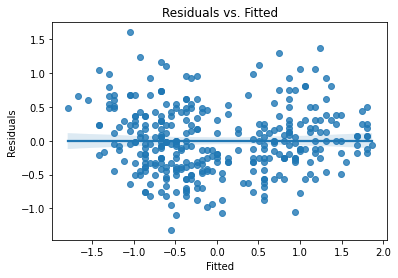

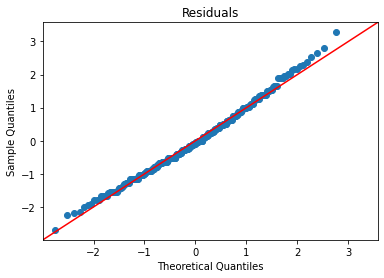

In [18]:
plot_lm_diag(bmf)

### Mass and Bill Length

Let's do a regression we don't expect to work well: mass vs. bill length.

First, we'll fit the regression:

In [19]:
bm_mod = smf.ols('mass ~ bill_len', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     186.4
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           3.81e-34
Time:                        15:29:51   Log-Likelihood:                -410.02
No. Observations:                 342   AIC:                             824.0
Df Residuals:                     340   BIC:                             831.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.75e-16      0.044   4.02e-15      1.000      -0.086       0.086
bill_len       0.5951      0.044     13.654      0.000       0.509       0.681
==============================================================================
Omnibus:                        5.671   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                4.857
Skew:                          -0.211   Prob(JB):                       0.0882
Kurtosis:                       2.597   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2$ is much lower than the previous models, indicating this model explains much less of the variance.

Let's look at our diagnostic plots:

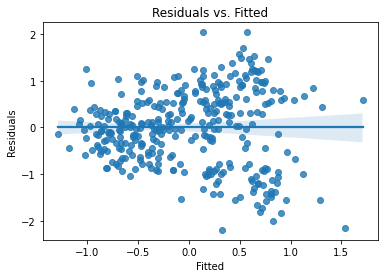

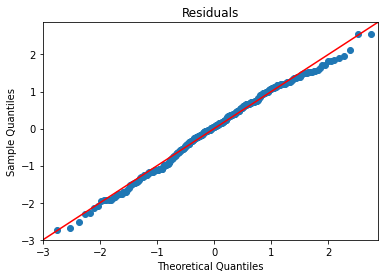

In [20]:
plot_lm_diag(bmf)

There's some noticable non-normality at the tails of the residuals, but it isn't bad. The residuals, however, exhibit notable heteroskedasticity,.

## Multivariate Regression

This section goes with the [Multiple Regression video](https://cs533.ekstrandom.net/content/week8/#multiple-regression).

### Per-Species Intercepts

Let's add the species as a predictor, so we have per-species intercepts for the variable:

In [21]:
bm_mod = smf.ols('mass ~ flipper + species', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     405.7
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          1.25e-111
Time:                        15:29:51   Log-Likelihood:                -223.79
No. Observations:                 342   AIC:                             455.6
Df Residuals:                     338   BIC:                             470.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0685      0.057     -1.207      0.228      -0.180       0.043
species[T.Chinstrap]    -0.2575      0.072     -3.577      0.000      -0.399      -0.116
species[T.Gentoo]        0.3327      0.119      2.801      0.005       0.099       0.566
flipper                  0.7137      0.054     13.255      0.000       0.608       0.820
==============================================================================
Omnibus:                        3.390   Durbin-Watson:                   2.556
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                3.397
Skew:                           0.242   Prob(JB):                        0.183
Kurtosis:                       2.934   Cond. No.                         6.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Species is automatically dummy-coded with the first level dropped.  We therefore get the following intercepts:

- Adelie: `Intercept`
- Chinstrap: `Intercept + species[T.Chinstrap]`
- Gentoo: `Intercept + species[T.Gentoo]`

Let's check fit:

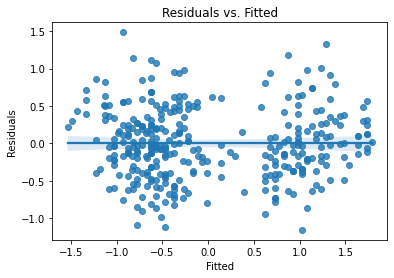

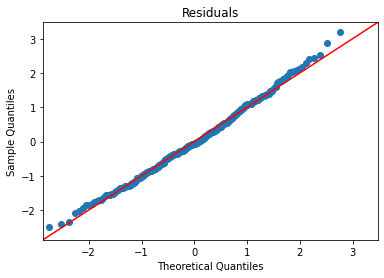

In [22]:
plot_lm_diag(bmf)

And we'll plot the different lines on top of a scatterplot:

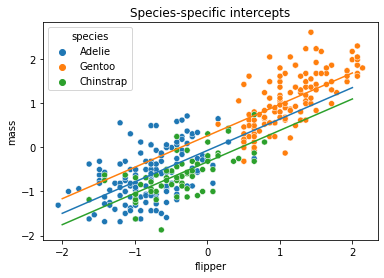

In [23]:
sns.scatterplot(x='flipper', y='mass', hue='species', data=penguin_std)
plot_line(bmf.params['Intercept'], bmf.params['flipper'], -2, 2, label='Adelie')
plot_line(bmf.params['Intercept'] + bmf.params['species[T.Gentoo]'],
          bmf.params['flipper'],
          -2, 2, label='Gentoo')
plot_line(bmf.params['Intercept'] + bmf.params['species[T.Chinstrap]'],
          bmf.params['flipper'],
          -2, 2, label='Chinstrap')
plt.title('Species-specific intercepts')
plt.show()

### Per-Species Slopes and Intercepts

Now let's add an interaction term between flipper and species.

We do this with `flipper * species`, which expands to `flipper + species + flipper:species`:

In [24]:
bm_mod = smf.ols('mass ~ flipper * species', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     252.2
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          2.22e-111
Time:                        15:29:52   Log-Likelihood:                -218.25
No. Observations:                 342   AIC:                             448.5
Df Residuals:                     336   BIC:                             471.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.1761      0.074     -2.393      0.017      -0.321      -0.031
species[T.Chinstrap]            -0.1888      0.101     -1.871      0.062      -0.387       0.010
species[T.Gentoo]                0.1579      0.135      1.172      0.242      -0.107       0.423
flipper                          0.5757      0.081      7.095      0.000       0.416       0.735
flipper:species[T.Chinstrap]     0.0305      0.138      0.222      0.825      -0.240       0.301
flipper:species[T.Gentoo]        0.3821      0.122      3.139      0.002       0.143       0.621
==============================================================================
Omnibus:                        5.822   Durbin-Watson:                   2.534
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.758
Skew:                           0.317   Prob(JB):                       0.0562
Kurtosis:                       3.034   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

AIC is improving slightly, not a lot.

Look at assumption checks:

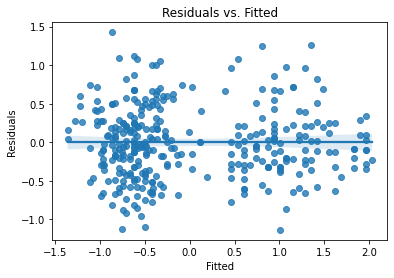

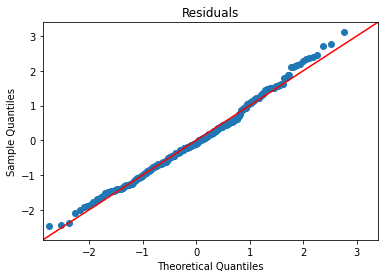

In [25]:
plot_lm_diag(bmf)

Getting better, but still some curve on the Q-Q and doesn't quite look homoskedastic.  (Watch the video for more explanation.)

Let's plot these different lines:

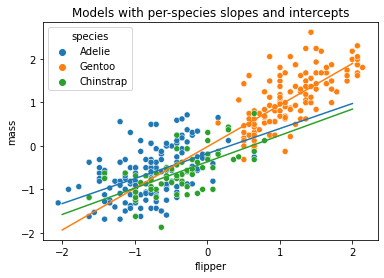

In [26]:
sns.scatterplot(x='flipper', y='mass', hue='species', data=penguin_std)
plot_line(bmf.params['Intercept'], bmf.params['flipper'], -2, 2, label='Adelie')
plot_line(bmf.params['Intercept'] + bmf.params['species[T.Gentoo]'],
          bmf.params['flipper'] + bmf.params['flipper:species[T.Gentoo]'],
          -2, 2, label='Gentoo')
plot_line(bmf.params['Intercept'] + bmf.params['species[T.Chinstrap]'],
          bmf.params['flipper'] + bmf.params['flipper:species[T.Chinstrap]'],
          -2, 2, label='Chinstrap')
plt.title('Models with per-species slopes and intercepts')
plt.show()

### Sexual Dimorphism

Now let's look at penguin sex as a predictor, and we'll keep the flipper:species interaction:

In [27]:
bm_mod = smf.ols('mass ~ flipper + species * sex + flipper:species', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     285.9
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          7.40e-142
Time:                        15:29:52   Log-Likelihood:                -125.89
No. Observations:                 333   AIC:                             269.8
Df Residuals:                     324   BIC:                             304.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.7717      0.076    -10.090      0.000      -0.922      -0.621
species[T.Chinstrap]                 0.2359      0.120      1.968      0.050    3.11e-05       0.472
species[T.Gentoo]                    1.0222      0.120      8.509      0.000       0.786       1.259
sex[T.male]                          0.7474      0.063     11.790      0.000       0.623       0.872
species[T.Chinstrap]:sex[T.male]    -0.5059      0.124     -4.086      0.000      -0.749      -0.262
species[T.Gentoo]:sex[T.male]       -0.0023      0.109     -0.021      0.983      -0.217       0.212
flipper                              0.2861      0.069      4.172      0.000       0.151       0.421
flipper:species[T.Chinstrap]         0.1817      0.126      1.442      0.150      -0.066       0.429
flipper:species[T.Gentoo]            0.1260      0.117      1.074      0.284      -0.105       0.357
==============================================================================
Omnibus:                        0.719   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.698   Jarque-Bera (JB):                0.836
Skew:                           0.083   Prob(JB):                        0.658
Kurtosis:                       2.819   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is good, but some non-significant relationships. In particular, the flipper/species interaction disappeared.

Assumption checks:

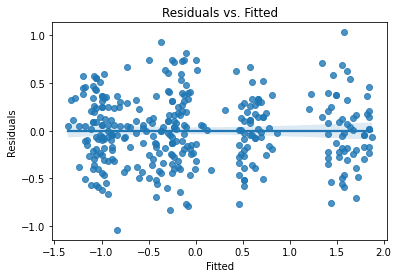

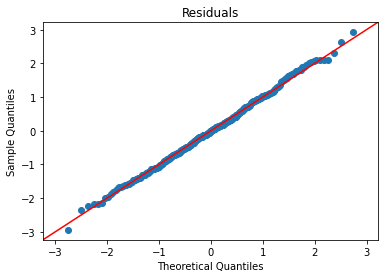

In [28]:
plot_lm_diag(bmf)

That is looking pretty good.

Drop interaction, due to non-significant coefficients:

In [29]:
bm_mod = smf.ols('mass ~ flipper + species * sex', data=penguin_std)
bmf = bm_mod.fit()
bmf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mass   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     380.2
Date:                Fri, 22 Oct 2021   Prob (F-statistic):          6.74e-144
Time:                        15:29:53   Log-Likelihood:                -127.17
No. Observations:                 333   AIC:                             268.3
Df Residuals:                     326   BIC:                             295.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.7034      0.062    -11.305      0.000      -0.826      -0.581
species[T.Chinstrap]                 0.0968      0.076      1.280      0.202      -0.052       0.246
species[T.Gentoo]                    0.9982      0.108      9.273      0.000       0.786       1.210
sex[T.male]                          0.7233      0.061     11.767      0.000       0.602       0.844
species[T.Chinstrap]:sex[T.male]    -0.4188      0.106     -3.953      0.000      -0.627      -0.210
species[T.Gentoo]:sex[T.male]        0.0549      0.090      0.612      0.541      -0.122       0.231
flipper                              0.3592      0.049      7.291      0.000       0.262       0.456
==============================================================================
Omnibus:                        0.476   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.788   Jarque-Bera (JB):                0.596
Skew:                           0.069   Prob(JB):                        0.742
Kurtosis:                       2.845   Cond. No.                         9.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is definitely the best AIC we've seen. Let's look at those assumption check plots:

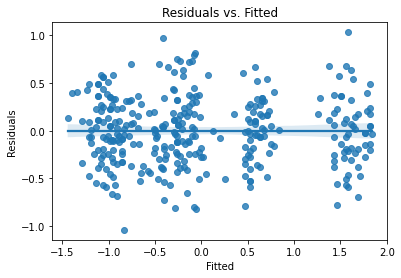

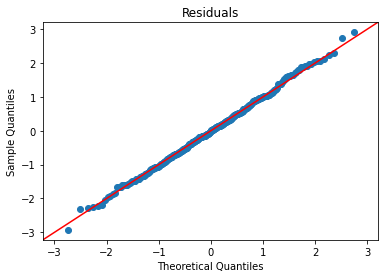

In [30]:
plot_lm_diag(bmf)

That looks quite good.

## Bootstrap

Now let's bootstrap some of these model parameters.  We'll start with a function that will compute bootstrap samples of the *rows* of a data frame, and pass them to a function to get a statistic:

In [31]:
def boot_rows(df, stat, nboot=10000):
    n = len(df)
    obs = stat(df)
    boots = [stat(df.sample(n=n, replace=True)) for i in range(nboot)]
    return obs, np.quantile(boots, [0.025, 0.975])

Now we'll write a function to train our full OLS model, and return the flipper length coefficient:

In [32]:
def flipper_coefficient(df):
    bm_mod = smf.ols('mass ~ flipper + species * sex', data=df)
    bmf = bm_mod.fit()
    return bmf.params['flipper']

And we'll bootstrap the flipper length coefficient:

In [33]:
boot_rows(penguin_std, flipper_coefficient, nboot=1000)

(0.3592089725886189, array([0.26818419, 0.45622605]))

That matches the CIs from the model itself pretty closely!

### Simultaneous Bootstrap of Multiple Parameters

In the video, I said you could do this. Here's the code.

First, we need a `boot_rows` function that can deal with the `stat` function returning a series of multiple statistics:

In [34]:
def boot_rows(df, stat, nboot=10000):
    n = len(df)
    obs = stat(df)
    boots = [stat(df.sample(n=n, replace=True)) for i in range(nboot)]
    if isinstance(obs, pd.Series):
        # we have multiple statistics - stack them into a frame
        boots = pd.DataFrame.from_records(boots)
        # compute confidence intervals - columns will be params, and rows CI bounds
        conf = boots.quantile([0.025, 0.975])
        # transpose will put the params on rows
        # join with frame-ified version of the original observations
        return obs.to_frame('value').join(conf.transpose())
    else:
        return obs, np.quantile(boots, [0.025, 0.975])

And a function to return the parameters from a trained model:

In [35]:
def flipper_params(df):
    bm_mod = smf.ols('mass ~ flipper + species * sex', data=df)
    bmf = bm_mod.fit()
    return bmf.params

And let's bootstrap all of this:

In [36]:
boot_rows(penguin_std, flipper_params, nboot=1000)

,value,0.025,0.975
Intercept,-0.703441,-0.816331,-0.593793
species[T.Chinstrap],0.096813,-0.040241,0.229157
species[T.Gentoo],0.998247,0.808552,1.206571
sex[T.male],0.723339,0.613021,0.847359
species[T.Chinstrap]:sex[T.male],-0.418757,-0.625197,-0.216513
species[T.Gentoo]:sex[T.male],0.054908,-0.113788,0.221861
flipper,0.359209,0.265790,0.448324
